In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader  
import numpy as np
from torch.utils.data import Dataset

def generate_tasks(p=0.5, d=100, c=1, n=300, alphas=[], betas=[]):
    '''
    d: dimensionality
    c: scaling factor
    p: correlation
    n: number of data points
    '''
    assert d >= 2, "at least 2 dimension"    
    u1, u2 = np.zeros(d), np.zeros(d)
    u1[0] = 1
    u2[1] = 1
    w1 = c * u1
    w2 = c * (p * u1 + np.sqrt(1-p**2) * u2)
    
    X = []
    Y1 = []
    Y2 = []
    for _ in range(n):
        x = np.random.normal(0, 1, d)
        y1 = w1.dot(x) + np.random.normal(0,0.01)
        y2 = w2.dot(x) + np.random.normal(0,0.01)
        for a, b in zip(alphas, betas):
            y1 += np.sin(a * w1.dot(x) + b)
            y2 += np.sin(a * w2.dot(x) + b)
            
        X.append(x)
        Y1.append(y1)
        Y2.append(y2)
    return np.vstack(X), np.array(Y1), np.array(Y2)

class CosDataset(Dataset):
    
    def __init__(self, p=0.5, d=100, c=1, n=300, alphas=[], betas=[]):
        '''
        d: dimensionality
        c: scaling factor
        p: correlation
        n: number of data points
        '''
        self.X, self.Y1, self.Y2 = generate_tasks(p=p,d=d,c=c,n=n,
                                                  alphas=alphas,betas=betas)
        self.X = torch.from_numpy(self.X).float()
        
    def __len__(self):
        return len(self.Y1)
    
    def __getitem__(self, idx):
        return self.X[idx], (self.Y1[idx], self.Y2[idx])
    
    
def MTL_loss():
    
    def c(yhat, y):
        # regression loss on 2 tasks
        y1, y2 = y
        yhat1, yhat2 = yhat
        c_ = torch.nn.MSELoss()
        return c_(yhat1.view(-1), y1.float().view(-1)) + c_(yhat2.view(-1), y2.float().view(-1))
        
    return c


In [2]:
import glob
import math 
import matplotlib.pyplot as plt
from lib.optimizer import RK4, DoublingRK4, Diff, DiffMax, AdamUnbiased, DiffUnbiased
from lib.model import Independent, SharedBottom, MMOE
from lib.train import TrainFeedForward

def loadTrainer(loadname, net):
    t = TrainFeedForward(net,
                         DataLoader(CosDataset(1)))
    t.load_checkpoint(loadname)
    return t

cos_sim = 0.2 # 0.0 0.2 0.4 0.6 0.8 1.0
alpha = 1.0 # 0.1 0.5 1.0

def collect_result(cos_sim, alpha, val=False):
    res = {}
    for i in range(1,11):
        for fn in glob.glob('independent3/{}/c={}/a={}/*'.format(i, cos_sim, alpha)):
            if 'best' not in fn:
                net = Independent(3) #SharedBottom(4)
                t = loadTrainer(fn, net)

                opt_name = fn.split('/')[-1].split('.')[0]
                if res.get(opt_name):
                    if val:
                        res[opt_name].append(t.val_losses)
                    else:
                        res[opt_name].append(t.train_losses)
                else:
                    if val:
                        res[opt_name] = [t.val_losses]
                    else:
                        res[opt_name] = [t.train_losses]
    return res



per layer neuron: 45
=> loading checkpoint 'independent3/1/c=0.2/a=1.0/SGD.pth.tar'
=> loaded checkpoint 'independent3/1/c=0.2/a=1.0/SGD.pth.tar' (iteration 1001)
per layer neuron: 45
=> loading checkpoint 'independent3/1/c=0.2/a=1.0/Sign.pth.tar'
=> loaded checkpoint 'independent3/1/c=0.2/a=1.0/Sign.pth.tar' (iteration 1001)
per layer neuron: 45
=> loading checkpoint 'independent3/1/c=0.2/a=1.0/Adam.pth.tar'
=> loaded checkpoint 'independent3/1/c=0.2/a=1.0/Adam.pth.tar' (iteration 1001)
per layer neuron: 45
=> loading checkpoint 'independent3/1/c=0.2/a=1.0/MomentumCurvature.pth.tar'
=> loaded checkpoint 'independent3/1/c=0.2/a=1.0/MomentumCurvature.pth.tar' (iteration 1001)
per layer neuron: 45
=> loading checkpoint 'independent3/1/c=0.2/a=1.0/Diff.pth.tar'
=> loaded checkpoint 'independent3/1/c=0.2/a=1.0/Diff.pth.tar' (iteration 1001)
per layer neuron: 45
=> loading checkpoint 'independent3/2/c=0.2/a=1.0/SGD.pth.tar'
=> loaded checkpoint 'independent3/2/c=0.2/a=1.0/SGD.pth.tar' (iter

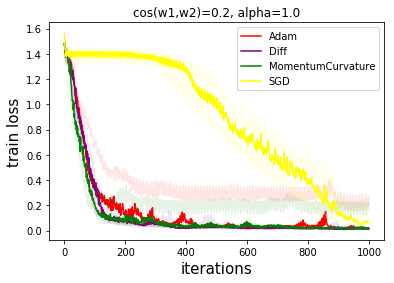

In [3]:
val = False
res = collect_result(cos_sim, alpha, val=val)

colors = ['red', 'purple', 'g', 'yellow', 'blue', 'orange', 'k', 'pink', 'brown', 'cyan', 'red']
for i, (k, v) in enumerate(sorted(res.items(),key=lambda a: a[0])):
    if k in ['Adam', 'Diff', 'SGD', 'MomentumCurvature']: #['Adam', 'Diff', 'SGD', 'Adamax', 'DoublingRK4']:
        try:
            plt.plot(np.percentile(v, 50, 0), label=k, c=colors[i])
            plt.plot(np.percentile(v, 25, 0), alpha=0.1, c=colors[i])
            plt.plot(np.percentile(v, 75, 0), alpha=0.1, c=colors[i])
        except:
            print(k, len(v))

plt.legend()
if val:
    plt.ylabel('val loss', fontsize=15)
else:
    plt.ylabel('train loss', fontsize=15)
plt.xlabel('iterations', fontsize=15)
plt.title('cos(w1,w2)={}, alpha={}'.format(cos_sim, alpha))
#plt.savefig('opt_figures/p={},a={}.png'.format(cos_sim, alpha))
plt.show()
